### 모듈 임포트

In [3]:
import numpy as np
from glob import glob
from PIL import Image
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import os
from PIL import ImageEnhance

### 이미지 데이터 불러오기

In [15]:
# 파일에 있는 jpg 파일의 경로를 각 변수에 저장

Non_office_path = glob("/Users/bchank/Team_project_2/original_dataset/Non-Office/*.jpg")
Office_path = glob("/Users/bchank/Team_project_2/original_dataset/Office/*.jpg")

# 경로와 라벨을 데이터 프레임으로 변경
# Non-office data의 라벨 -> 0  
# office data의 라벨 -> 1  

Non_office = pd.DataFrame(Non_office_path, columns=['path'])
Non_office['label'] = 0

office = pd.DataFrame(Office_path, columns=['path'])
office['label'] = 1

# 데이터 경로 저장
data_path = pd.concat([Non_office, office])

# 원본 이미지 데이터 3,800개 
# csv 파일로 경로와 라벨 데이터를 저장

print(len(data_path))
data_path.to_csv('data_path.csv',index=False)
data_path

3800


,path,label
0,/Users/bchank/Team_project_2/original_dataset/...,0
1,/Users/bchank/Team_project_2/original_dataset/...,0
2,/Users/bchank/Team_project_2/original_dataset/...,0
3,/Users/bchank/Team_project_2/original_dataset/...,0
4,/Users/bchank/Team_project_2/original_dataset/...,0
...,...,...
2394,/Users/bchank/Team_project_2/original_dataset/...,1
2395,/Users/bchank/Team_project_2/original_dataset/...,1
2396,/Users/bchank/Team_project_2/original_dataset/...,1
2397,/Users/bchank/Team_project_2/original_dataset/...,1


### 이미지 전처리 (사이즈 조정, 정규화) 및 npy 파일 저장

In [10]:
data = pd.read_csv('data_path.csv')

# 데이터셋 1, 2, 3을 학습한 모델 성능을 비교하기 위한 테스트 셋 데이터를 원본에서 추출 
# 800개의 데이터를 추출하고 이후 모델 간 성능 비교 

test_data = data.sample(n = 800, random_state = 42)
drop_index = test_data.index
data.drop(drop_index, axis=0, inplace=True)

# 테스트 데이터 추출 후 원본 데이터의 갯수, 테스트 데이터의 갯수 
len(data), len(test_data)

(3000, 800)

In [13]:
# 원본 데이터의 label을 npy파일로 저장

labels_origin = data['label']
np.save('labels_origin.npy', labels_origin)

print(labels_origin.shape)

(3000,)


In [14]:
# target_size를 (224, 224)로 지정
# 원본 이미지 데이터 전처리 후 npy파일로 저장

target_size = (224, 224)
images = []
images_path = data['path']          # glob으로 불러온 이미지의 파일 경로

for image_path in tqdm(images_path):
    image = Image.open(image_path)
    image_resized = image.resize(target_size)
    image_rgb = image_resized.convert("RGB")    # 이미지를 RGB로 변환
    image_array = np.array(image_rgb)
    normalized_image = image_array / 255.0  # 이미지를 0과 1 사이로 정규화
    images.append(normalized_image)

# 이미지 배열의 크기를 확인하여 모든 이미지가 동일한 크기로 변환되었는지 확인
image_shapes = [image.shape for image in images]
unique_shapes = set(image_shapes)
if len(unique_shapes) > 1:
    print("이미지 배열의 크기가 다릅니다. 동일한 크기로 변환해주세요.")
else:
    images_origin = np.array(images)
    np.save('images_origin.npy', images_origin)   # 전처리된 이미지를 npy 파일로 저장

print(images_origin.shape)

100%|██████████████████████████████████████| 3000/3000 [00:23<00:00, 128.36it/s]


(3000, 224, 224, 3)


In [15]:
# target_size를 (224, 224)로 지정
# 테스트 데이터 전처리 후 npy파일로 저장

target_size = (224, 224)
images = []
images_path = test_data['path']          # glob으로 불러온 이미지의 파일 경로

for image_path in tqdm(images_path):
    image = Image.open(image_path)
    image_resized = image.resize(target_size)
    image_rgb = image_resized.convert("RGB")    # 이미지를 RGB로 변환
    image_array = np.array(image_rgb)
    normalized_image = image_array / 255.0  # 이미지를 0과 1 사이로 정규화
    images.append(normalized_image)

# 이미지 배열의 크기를 확인하여 모든 이미지가 동일한 크기로 변환되었는지 확인
image_shapes = [image.shape for image in images]
unique_shapes = set(image_shapes)
if len(unique_shapes) > 1:
    print("이미지 배열의 크기가 다릅니다. 동일한 크기로 변환해주세요.")
else:
    images_test = np.array(images)
    np.save('images_test.npy', images_test)   # 전처리된 이미지를 npy 파일로 저장

print(images_test.shape)

100%|████████████████████████████████████████| 800/800 [00:06<00:00, 129.25it/s]


(800, 224, 224, 3)


In [16]:
# 원본 데이터의 label을 npy파일로 저장

labels_test = test_data['label']
np.save('labels_test.npy', labels_test)

print(labels_test.shape)

(800,)


### 이미지 증강 (좌우 반전)

In [17]:
# 도메인을 분류하여 이미지 증강 진행

data_nonoffice = data[(data['label']== 0)]
data_office = data[(data['label']== 1)]

len(data_nonoffice) + len(data_office)

3000

In [18]:
# 이미지 좌우 반전 함수 - office 도메인의 이미지 데이터에 적용 

def horizontal_flip(image):
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return flipped_image

# Non-office data의 라벨 -> 0  
# office data의 라벨 -> 1  

images = []
images_path = data_office['path']

for image_path in tqdm(images_path):
    image = Image.open(image_path)
    flipped_image = horizontal_flip(image)
    file_name = os.path.splitext(os.path.basename(image_path))[0]

    image.save(f'/Users/bchank/Team_project_2/flipped_dataset/Office/{file_name}.jpg')                     # 원본 이미지 저장 
    flipped_image.save(f'/Users/bchank/Team_project_2/flipped_dataset/Office/{file_name}_flipped.jpg')     # 상하 반전된 이미지 저장

100%|██████████████████████████████████████| 1909/1909 [00:11<00:00, 168.67it/s]


In [19]:
# 이미지 좌우 반전 함수 - non-office 도메인의 이미지 데이터에 적용 

def horizontal_flip(image):
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return flipped_image

# Non-office data의 라벨 -> 0  
# office data의 라벨 -> 1  

images = []
images_path = data_nonoffice['path']

for image_path in tqdm(images_path):
    image = Image.open(image_path)
    flipped_image = horizontal_flip(image)
    file_name = os.path.splitext(os.path.basename(image_path))[0]
    
    image.save(f'/Users/bchank/Team_project_2/flipped_dataset/Non-Office/{file_name}.jpg')                     # 원본 이미지 저장 
    flipped_image.save(f'/Users/bchank/Team_project_2/flipped_dataset/Non-Office/{file_name}_flipped.jpg') # 증강된 이미지 저장 

100%|███████████████████████████████████████| 1091/1091 [00:30<00:00, 35.70it/s]


### 이미지 증강(밝기 조절)

In [20]:
# 이미지 데이터의 밝기를 조절하는 함수 
# 저조한 조명 환경을 고려하여 이미지의 밝기를 어둡게 하기 위해 enhance의 파라미터를 0.7로 지정
# Non-office 도메인의 이미지 데이터 증강

def brightness(image):
    
    enhancer = ImageEnhance.Brightness(image)
    adjusted_image = enhancer.enhance(0.7)
    return adjusted_image

images = []
images_path = data_nonoffice['path']

for image_path in tqdm(images_path):
    image = Image.open(image_path)
    adjusted_image = brightness(image)
    
    file_name = os.path.splitext(os.path.basename(image_path))[0]
    adjusted_image.save(f'/Users/bchank/Team_project_2/brightness_dataset/Non-Office/{file_name}_brightness.jpg')

100%|███████████████████████████████████████| 1091/1091 [00:21<00:00, 49.67it/s]


In [21]:
# 이미지 데이터의 밝기를 조절하는 함수 
# 저조한 조명 환경을 고려하여 이미지의 밝기를 어둡게 하기 위해 enhance의 파라미터를 0.7로 지정
# office 도메인의 이미지 데이터 증강

def brightness(image):
    
    enhancer = ImageEnhance.Brightness(image)
    adjusted_image = enhancer.enhance(0.7)
    return adjusted_image

images = []
images_path = data_office['path']

for image_path in tqdm(images_path):
    image = Image.open(image_path)
    adjusted_image = brightness(image)
    
    file_name = os.path.splitext(os.path.basename(image_path))[0]
    adjusted_image.save(f'/Users/bchank/Team_project_2/brightness_dataset/Office/{file_name}_brightness.jpg')

100%|██████████████████████████████████████| 1909/1909 [00:06<00:00, 284.51it/s]


In [22]:
# flipped_dataset 파일에 있는 jpg 파일의 경로를 각 변수에 저장

Non_office_path = glob("/Users/bchank/Team_project_2/flipped_dataset/Non-Office/*.jpg")
Office_path = glob("/Users/bchank/Team_project_2/flipped_dataset/Office/*.jpg")

# 경로와 라벨을 데이터 프레임으로 변경
# Non-office data의 라벨 -> 0  
# office data의 라벨 -> 1  

Non_office = pd.DataFrame(Non_office_path, columns=['path'])
Non_office['label'] = 0

office = pd.DataFrame(Office_path, columns=['path'])
office['label'] = 1

# 데이터 경로 저장
data_path_flipped = pd.concat([Non_office, office])

# 원본 이미지 데이터 3,800개 
# csv 파일로 경로와 라벨 데이터를 저장

print(len(data_path_flipped))
data_path_flipped.to_csv('data_path_flipped.csv',index=False)
data_path_flipped

6000


,path,label
0,/Users/bchank/Team_project_2/flipped_dataset/N...,0
1,/Users/bchank/Team_project_2/flipped_dataset/N...,0
2,/Users/bchank/Team_project_2/flipped_dataset/N...,0
3,/Users/bchank/Team_project_2/flipped_dataset/N...,0
4,/Users/bchank/Team_project_2/flipped_dataset/N...,0
...,...,...
3813,/Users/bchank/Team_project_2/flipped_dataset/O...,1
3814,/Users/bchank/Team_project_2/flipped_dataset/O...,1
3815,/Users/bchank/Team_project_2/flipped_dataset/O...,1
3816,/Users/bchank/Team_project_2/flipped_dataset/O...,1


In [23]:
# target_size를 (224, 224)로 지정
# flipped 이미지 데이터 전처리 후 npy파일로 저장

target_size = (224, 224)
images = []
images_path = data_path_flipped['path']          # glob으로 불러온 이미지의 파일 경로

for image_path in tqdm(images_path):
    image = Image.open(image_path)
    image_resized = image.resize(target_size)
    image_rgb = image_resized.convert("RGB")    # 이미지를 RGB로 변환
    image_array = np.array(image_rgb)
    normalized_image = image_array / 255.0  # 이미지를 0과 1 사이로 정규화
    images.append(normalized_image)

# 이미지 배열의 크기를 확인하여 모든 이미지가 동일한 크기로 변환되었는지 확인
image_shapes = [image.shape for image in images]
unique_shapes = set(image_shapes)
if len(unique_shapes) > 1:
    print("이미지 배열의 크기가 다릅니다. 동일한 크기로 변환해주세요.")
else:
    images_flipped = np.array(images)
    np.save('images_flipped.npy', images_flipped)   # 전처리된 이미지를 npy 파일로 저장

print(images_flipped.shape)

100%|██████████████████████████████████████| 6000/6000 [00:47<00:00, 126.90it/s]


(6000, 224, 224, 3)


In [24]:
# 반전된 이미지 데이터의 label을 npy파일로 저장

flipped = pd.read_csv('data_path_flipped.csv')
labels_flipped = flipped['label']
np.save('labels_flipped.npy', labels_flipped)

print(labels_flipped.shape)

(6000,)


In [25]:
# 밝기가 조정된 dataset 파일에 있는 jpg 파일의 경로를 각 변수에 저장

Non_office_path = glob("/Users/bchank/Team_project_2/brightness_dataset/Non-Office/*.jpg")
Office_path = glob("/Users/bchank/Team_project_2/brightness_dataset/Office/*.jpg")

# 경로와 라벨을 데이터 프레임으로 변경
# Non-office data의 라벨 -> 0  
# office data의 라벨 -> 1  

Non_office = pd.DataFrame(Non_office_path, columns=['path'])
Non_office['label'] = 0

office = pd.DataFrame(Office_path, columns=['path'])
office['label'] = 1

# 데이터 경로 저장
data_path_brightness = pd.concat([Non_office, office])

# 원본 이미지 데이터 3,800개 
# csv 파일로 경로와 라벨 데이터를 저장

print(len(data_path_brightness))
data_path_brightness.to_csv('data_path_brightness.csv',index=False)
data_path_brightness

9000


,path,label
0,/Users/bchank/Team_project_2/brightness_datase...,0
1,/Users/bchank/Team_project_2/brightness_datase...,0
2,/Users/bchank/Team_project_2/brightness_datase...,0
3,/Users/bchank/Team_project_2/brightness_datase...,0
4,/Users/bchank/Team_project_2/brightness_datase...,0
...,...,...
5722,/Users/bchank/Team_project_2/brightness_datase...,1
5723,/Users/bchank/Team_project_2/brightness_datase...,1
5724,/Users/bchank/Team_project_2/brightness_datase...,1
5725,/Users/bchank/Team_project_2/brightness_datase...,1


In [26]:
# target_size를 (224, 224)로 지정
# 밝기 조정 이미지 데이터 전처리 후 npy파일로 저장

target_size = (224, 224)
images = []
images_path = data_path_brightness['path']          # glob으로 불러온 이미지의 파일 경로

for image_path in tqdm(images_path):
    image = Image.open(image_path)
    image_resized = image.resize(target_size)
    image_rgb = image_resized.convert("RGB")    # 이미지를 RGB로 변환
    image_array = np.array(image_rgb)
    normalized_image = image_array / 255.0  # 이미지를 0과 1 사이로 정규화
    images.append(normalized_image)

# 이미지 배열의 크기를 확인하여 모든 이미지가 동일한 크기로 변환되었는지 확인
image_shapes = [image.shape for image in images]
unique_shapes = set(image_shapes)
if len(unique_shapes) > 1:
    print("이미지 배열의 크기가 다릅니다. 동일한 크기로 변환해주세요.")
else:
    images_brightness = np.array(images)
    np.save('images_brightness.npy', images_brightness)   # 전처리된 이미지를 npy 파일로 저장

print(images_brightness.shape)

100%|██████████████████████████████████████| 9000/9000 [01:10<00:00, 127.69it/s]


(9000, 224, 224, 3)


In [27]:
# 밝기가 조정된 데이터의 label을 npy파일로 저장

labels_brightness = data_path_brightness['label']
np.save('labels_brightness.npy', labels_brightness)

print(labels_brightness.shape)

(9000,)


### 이미지 시각화

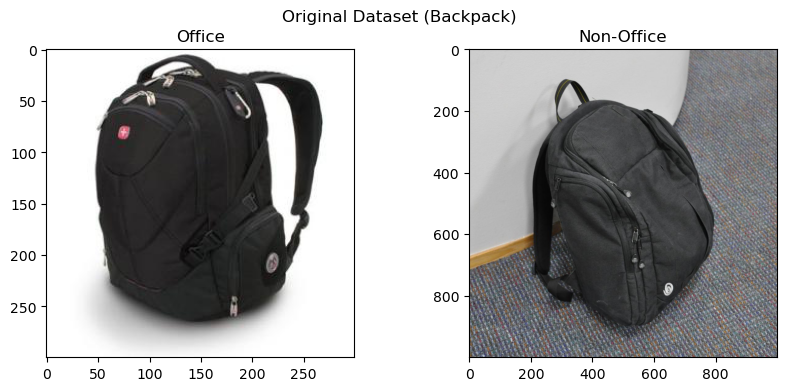

In [28]:
image = Image.open("/Users/bchank/Team_project_2/original_dataset/Office/backpack_0001.jpg")
image2 = Image.open("/Users/bchank/Team_project_2/original_dataset/Non-Office/backpack_0001.jpg")


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Office')

#ㅁ
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Non-Office')

plt.suptitle('Original Dataset (Backpack)')
plt.savefig('Domain_backpack.png')

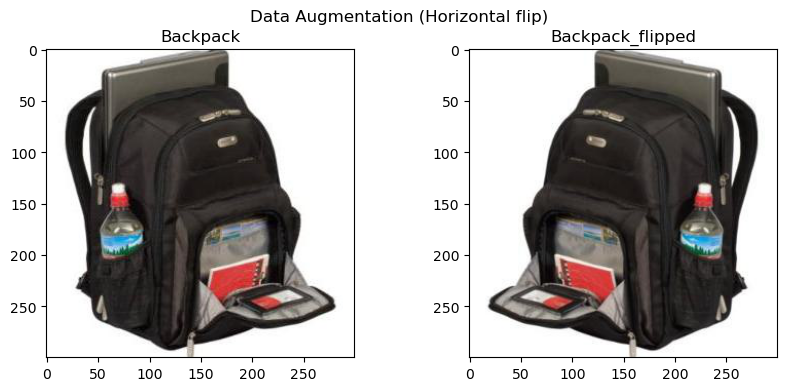

In [29]:
image = Image.open("/Users/bchank/Team_project_2/flipped_dataset/Office/backpack_0036_flipped.jpg")
image2 = Image.open("/Users/bchank/Team_project_2/flipped_dataset/Office/backpack_0036.jpg")


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Backpack')

#ㅁ
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Backpack_flipped')

plt.suptitle('Data Augmentation (Horizontal flip)')
plt.savefig('Data Augmentation (Horizontal flip).png')

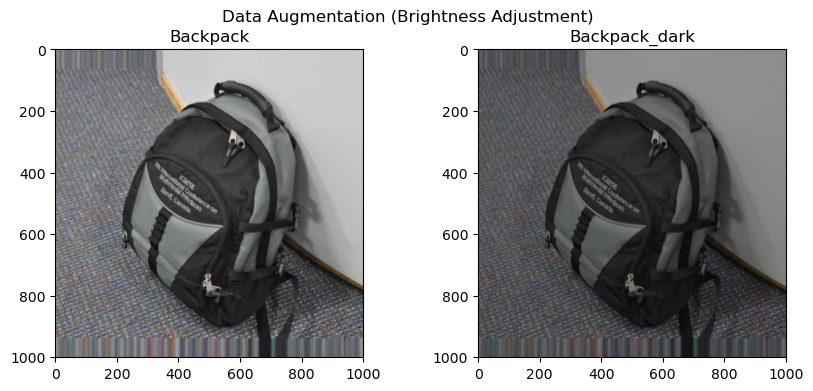

In [30]:
image = Image.open("/Users/bchank/Team_project_2/brightness_dataset/Non-Office/backpack_0007.jpg")
image2 = Image.open("/Users/bchank/Team_project_2/brightness_dataset/Non-Office/backpack_0007_brightness.jpg")


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Backpack')

#ㅁ
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Backpack_dark')

plt.suptitle('Data Augmentation (Brightness Adjustment)')
plt.savefig('Data Augmentation (Brightness Adjustment).png')